# AWS Deep Racer - Hyperparameter and Reward Function Bayesian Optimization

This Jupyter notebook aims to enhance the AWS DeepRacer model by focusing on two critical aspects: optimizing the Convolutional Neural Network (CNN) training hyperparameters and refining the reward function. Given the constraint of limited training time, the approach is divided into two main parts:

### Reward Function Design:

- Implement a set of predefined reward functions, each with a specific focus on improving the car's performance on the re2018 track.
- Use evolutionary strategies to evolve the structure of the reward function and Bayesian optimization to fine-tune the hyperparameters for each reward function.

### Hyperparameter Tuning:

- Employ Bayesian optimization to systematically explore the hyperparameter space and identify the optimal settings that maximize the performance of the reward functions.

### Reward Functions
Here are several reward functions designed to address different aspects of the car's performance:

#### Reward Function 1: Waypoint-Based Direction Alignment

Rewards the car for aligning its heading with the direction between waypoints.

In [1]:
import math

def reward_function_1(params, hyperparams):
    waypoints = params['waypoints']
    closest_waypoints = params['closest_waypoints']
    heading = params['heading']
    reward = 1.0

    next_point = waypoints[closest_waypoints[1]]
    prev_point = waypoints[closest_waypoints[0]]
    track_direction = math.atan2(next_point[1] - prev_point[1], next_point[0] - prev_point[0])
    track_direction = math.degrees(track_direction)
    direction_diff = abs(track_direction - heading)
    if direction_diff > 180:
        direction_diff = 360 - direction_diff

    if direction_diff < hyperparams['DIRECTION_THRESHOLD']:
        reward += hyperparams['DIRECTION_REWARD']
    else:
        reward -= hyperparams['DIRECTION_PENALTY']

    return float(reward)

#### Reward Function 2: Distance from Center Line

Rewards the car for staying close to the center of the track.

In [2]:
def reward_function_2(params, hyperparams):
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    reward = 1.0

    marker_1 = 0.1 * track_width
    marker_2 = 0.25 * track_width
    marker_3 = 0.5 * track_width

    if distance_from_center <= marker_1:
        reward += hyperparams['CENTER_REWARD_1']
    elif distance_from_center <= marker_2:
        reward += hyperparams['CENTER_REWARD_2']
    elif distance_from_center <= marker_3:
        reward += hyperparams['CENTER_REWARD_3']
    else:
        reward += hyperparams['CENTER_REWARD_4']

    return float(reward)

#### Reward Function 3: Speed Control

Rewards the car for maintaining optimal speed and penalizes low speed.

In [3]:
def reward_function_3(params, hyperparams):
    speed = params['speed']
    reward = 1.0

    if speed > hyperparams['SPEED_THRESHOLD']:
        reward += hyperparams['HIGH_SPEED_REWARD']
    else:
        reward -= hyperparams['LOW_SPEED_PENALTY']

    return float(reward)

#### Reward Function 4: All Wheels on Track

Rewards the car for keeping all wheels on the track and penalizes when it goes off-track.

In [4]:
def reward_function_4(params, hyperparams):
    all_wheels_on_track = params['all_wheels_on_track']
    reward = 1.0

    if all_wheels_on_track:
        reward += hyperparams['ALL_WHEELS_REWARD']
    else:
        reward -= hyperparams['OFF_TRACK_PENALTY']

    return float(reward)


#### Reward Function 5: Optimized Corridor

Rewards the car for staying within an optimized corridor around the ideal racing line.

In [5]:
def reward_function_5(params, hyperparams):
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    is_offtrack = params['is_offtrack']
    reward = 1.0

    marker_1 = 0.1 * track_width
    marker_2 = 0.2 * track_width
    marker_3 = 0.3 * track_width

    if is_offtrack:
        reward = hyperparams['OFF_TRACK_PENALTY']
    elif distance_from_center <= marker_1:
        reward = hyperparams['MARKER_1_REWARD']
    elif distance_from_center <= marker_2:
        reward = hyperparams['MARKER_2_REWARD']
    elif distance_from_center <= marker_3:
        reward = hyperparams['MARKER_3_REWARD']
    else:
        reward = hyperparams['MARKER_4_REWARD']

    return float(reward)


#### Reward Function 6: Progressive Reward for Speed and Progress

Rewards progressive progress and speed, ensuring that the car maintains a good balance between speed and controlled progress.

In [6]:
def reward_function_6(params, hyperparams):
    progress = params['progress']
    speed = params['speed']
    reward = 1.0

    reward += hyperparams['PROGRESS_FACTOR'] * progress

    if speed < hyperparams['MIN_SPEED']:
        reward -= hyperparams['SPEED_PENALTY']
    else:
        reward += hyperparams['SPEED_REWARD']

    return float(reward)


#### Reward Function 7: Dynamic Steering Angle Adjustment

Rewards for maintaining a reasonable steering angle to avoid sharp turns.

In [7]:
def reward_function_7(params, hyperparams):
    steering_angle = abs(params['steering_angle'])
    reward = 1.0

    if steering_angle < hyperparams['STEERING_THRESHOLD']:
        reward += hyperparams['STEERING_REWARD']
    else:
        reward -= hyperparams['STEERING_PENALTY']

    return float(reward)


#### Reward Function 8: Tailored to Specific Waypoints

This reward function overfits the model to specific waypoints of the circuit where the competition will take place:

In [10]:
def reward_function_8(params, hyperparams):
    nextWaypoint = params['closest_waypoints'][1]
    speed = params['speed']
    steering_angle = params['steering_angle']
    reward = 1.0

    slow = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,  50,51,52,53,  61,62,63,64,65,66,67,68] #1
    if nextWaypoint in slow:
        if speed <= 2 or speed > 1:
            reward += hyperparams['SLOW_SPEED_REWARD']
        else:
            reward -= hyperparams['SLOW_SPEED_PENALTY']

    moderate = [10,  33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,  54,55,56,57,58,59,60] #2
    if nextWaypoint in moderate:
        if speed > 2 and speed <= 2.5:
            reward += hyperparams['MODERATE_SPEED_REWARD']
        else:
            reward -= hyperparams['MODERATE_SPEED_PENALTY']
    
    fast = [0,1,2,3,4,5,6,7,8,9,   25,26,27,28,29,30,31,32,    69,70] #3
    if nextWaypoint in fast:
        if speed > 2.5:
            reward += hyperparams['FAST_SPEED_REWARD']
        else:
            reward -= hyperparams['FAST_SPEED_PENALTY']
        if abs(steering_angle) > 12:
            reward -= hyperparams['STEERING_PENALTY']
        else:
            reward -= hyperparams['LOW_STEERING_PENALTY']

    left_lane = [21,22,23,24,25,26,27,28,  37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70]
    right_lane = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,   29,30,31,32,33,34,35,36]
    
    if nextWaypoint in left_lane and params["is_left_of_center"]:
        reward += hyperparams['LEFT_LANE_REWARD']
    elif nextWaypoint in right_lane and not params["is_left_of_center"]:
        reward += hyperparams['RIGHT_LANE_REWARD']
    else:
        reward -= hyperparams['LANE_PENALTY']
    
    return float(reward)

## Hyperparameter Tuning Using Bayesian Optimization

To optimize the hyperparameters for each reward function, Bayesian optimization is employed.

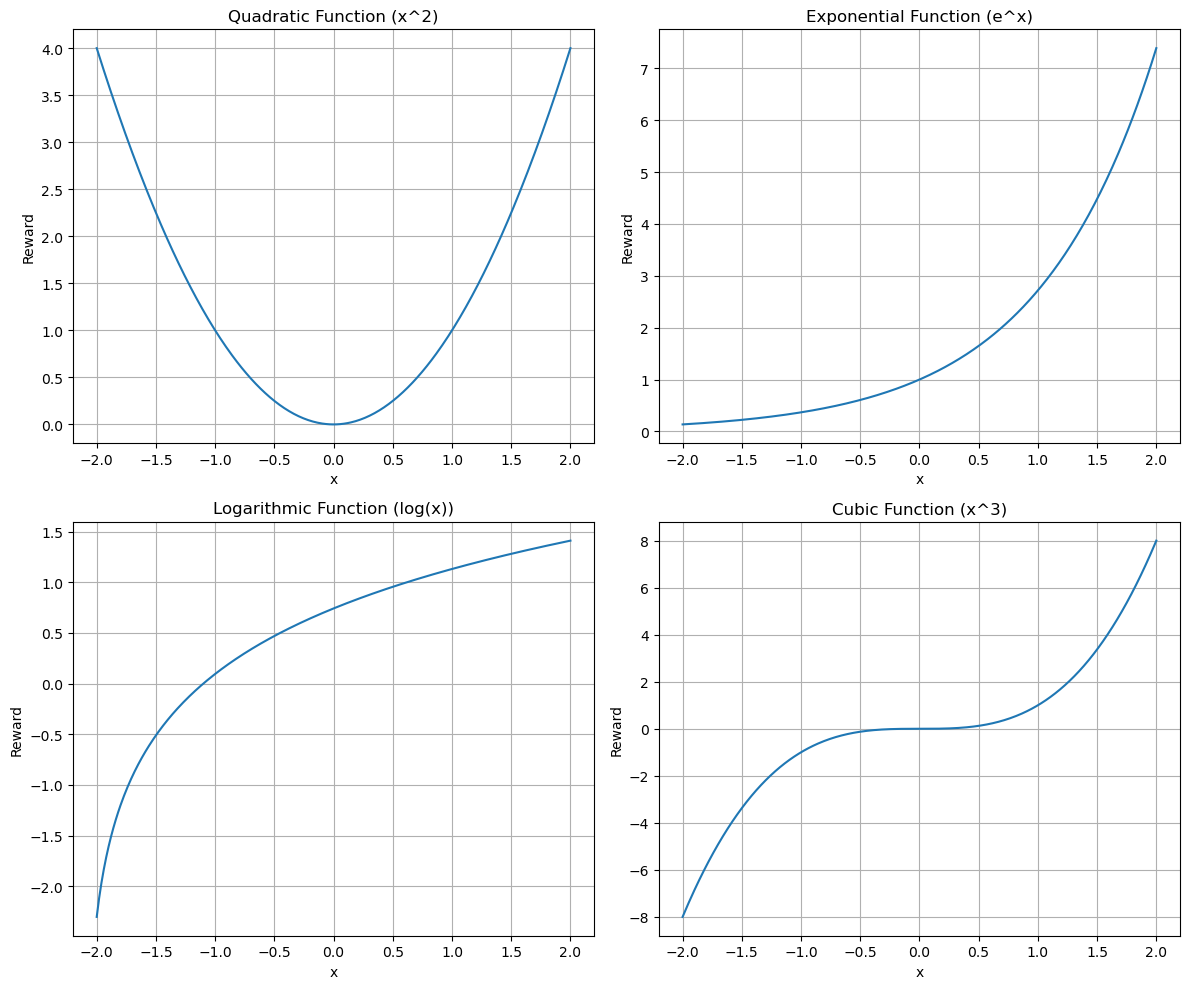

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range for x values
x = np.linspace(-2, 2, 400)

# Define the reward functions
def quadratic_function(x):
    return x**2

def exponential_function(x):
    return np.exp(x)

def logarithmic_function(x):
    return np.log(x + 2.1)  # Shifted to avoid log(0) issues

def cubic_function(x):
    return x**3

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Quadratic Function
axs[0, 0].plot(x, quadratic_function(x))
axs[0, 0].set_title('Quadratic Function (x^2)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Reward')
axs[0, 0].grid()

# Plot Exponential Function
axs[0, 1].plot(x, exponential_function(x))
axs[0, 1].set_title('Exponential Function (e^x)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Reward')
axs[0, 1].grid()

# Plot Logarithmic Function
axs[1, 0].plot(x, logarithmic_function(x))
axs[1, 0].set_title('Logarithmic Function (log(x))')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Reward')
axs[1, 0].grid()

# Plot Cubic Function
axs[1, 1].plot(x, cubic_function(x))
axs[1, 1].set_title('Cubic Function (x^3)')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Reward')
axs[1, 1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

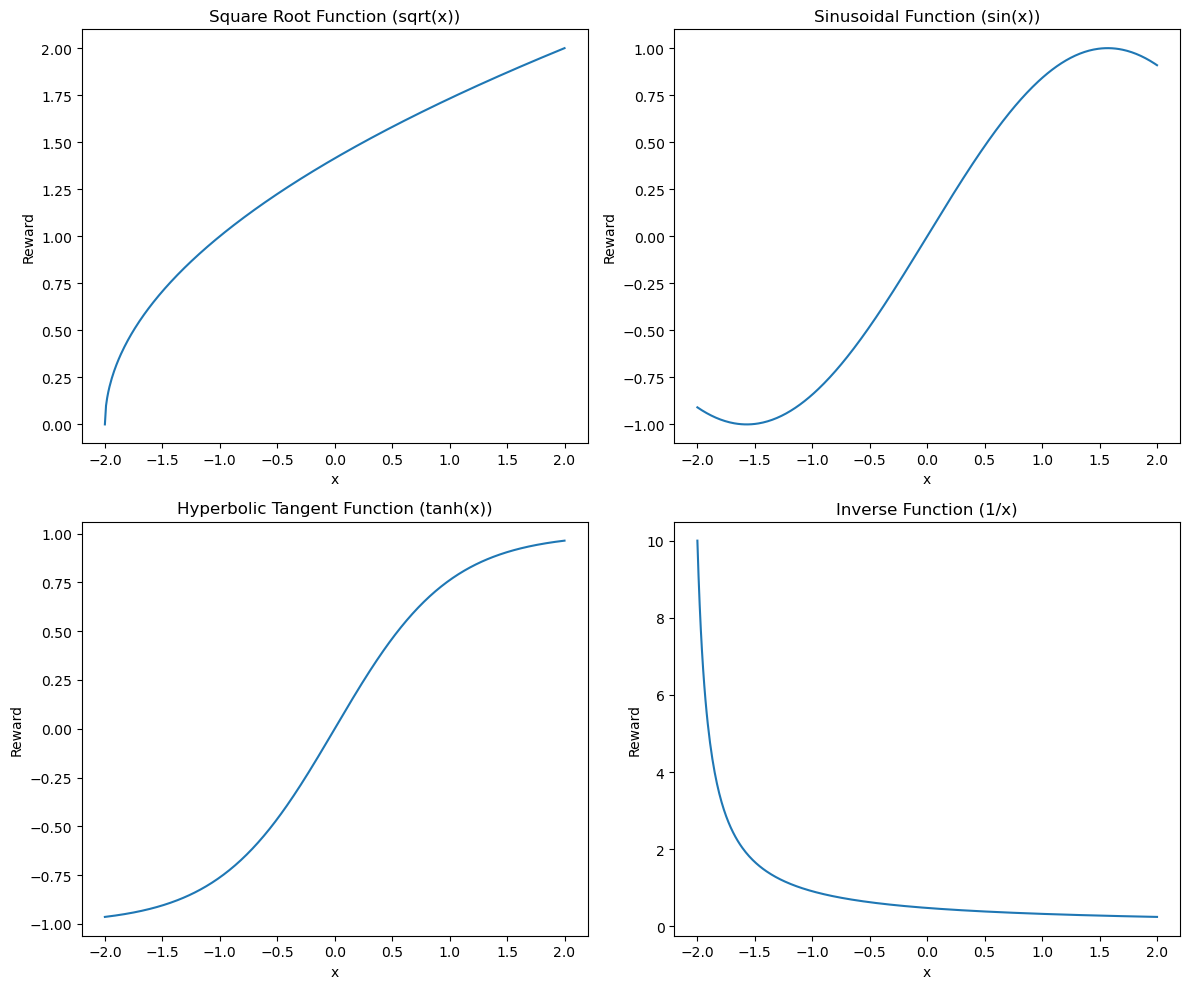

In [2]:
# Add additional reward functions to the visualization

# Define the range for x values
x = np.linspace(-2, 2, 400)

# Define the additional reward functions
def sqrt_function(x):
    return np.sqrt(x + 2)  # Shifted to avoid sqrt of negative numbers

def sinusoidal_function(x):
    return np.sin(x)

def tanh_function(x):
    return np.tanh(x)

def inverse_function(x):
    return 1 / (x + 2.1)  # Shifted to avoid division by zero

# Create a figure with subplots for additional functions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Square Root Function
axs[0, 0].plot(x, sqrt_function(x))
axs[0, 0].set_title('Square Root Function (sqrt(x))')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Reward')

# Plot Sinusoidal Function
axs[0, 1].plot(x, sinusoidal_function(x))
axs[0, 1].set_title('Sinusoidal Function (sin(x))')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Reward')

# Plot Hyperbolic Tangent Function
axs[1, 0].plot(x, tanh_function(x))
axs[1, 0].set_title('Hyperbolic Tangent Function (tanh(x))')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Reward')

# Plot Inverse Function
axs[1, 1].plot(x, inverse_function(x))
axs[1, 1].set_title('Inverse Function (1/x)')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Reward')

# Adjust layout
plt.tight_layout()
plt.show()


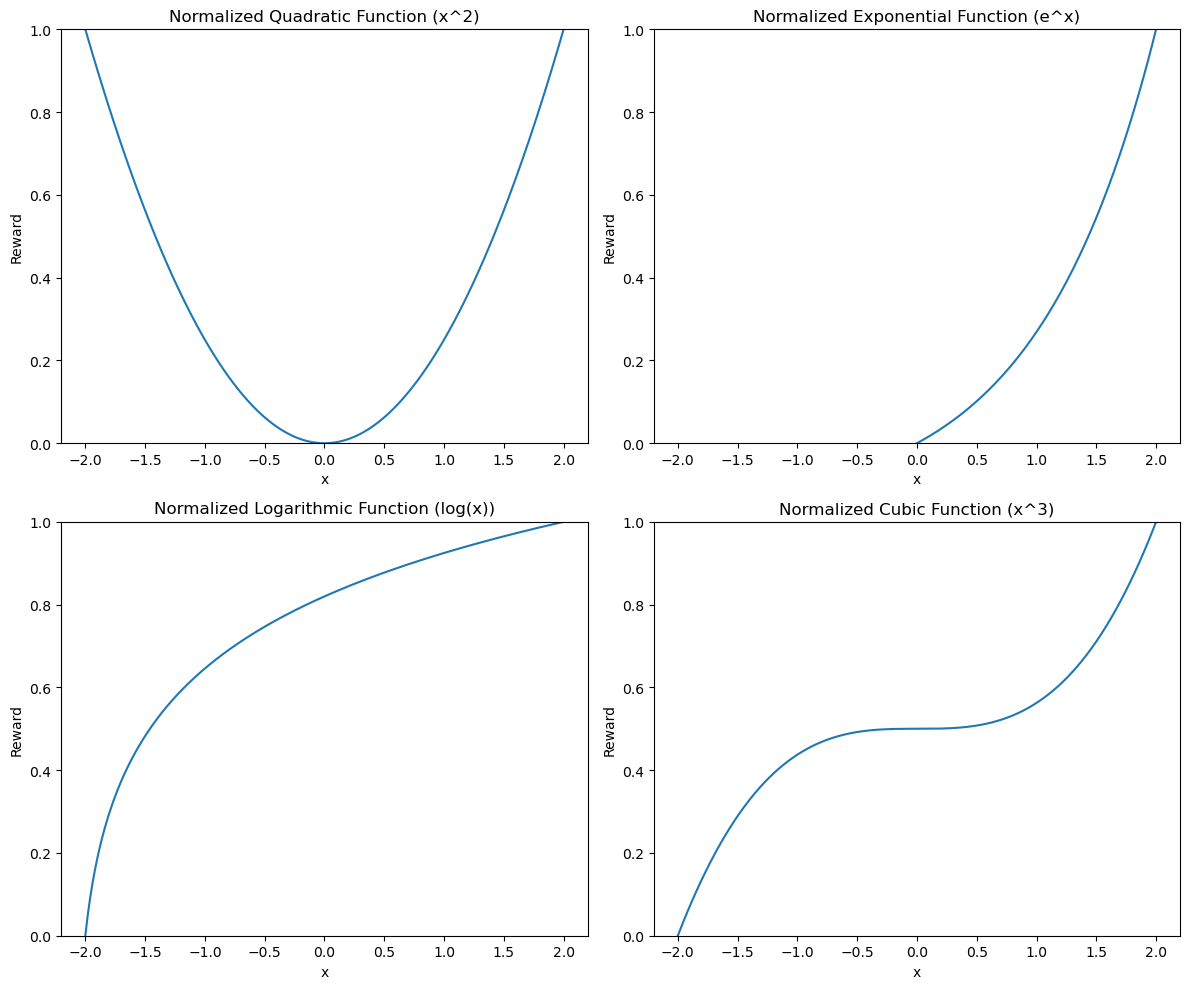

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range for x values
x = np.linspace(-2, 2, 400)

# Define the reward functions
def normalized_quadratic_function(x):
    return (x**2) / 4.0

def normalized_exponential_function(x):
    return (np.exp(x) - 1) / (np.exp(2) - 1)

def normalized_logarithmic_function(x):
    return (np.log(x + 2.1) - np.log(0.1)) / (np.log(4.1) - np.log(0.1))

def normalized_cubic_function(x):
    return (x**3 + 8) / 16.0

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Normalized Quadratic Function
axs[0, 0].plot(x, normalized_quadratic_function(x))
axs[0, 0].set_title('Normalized Quadratic Function (x^2)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Reward')
axs[0, 0].set_ylim([0, 1])

# Plot Normalized Exponential Function
axs[0, 1].plot(x, normalized_exponential_function(x))
axs[0, 1].set_title('Normalized Exponential Function (e^x)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Reward')
axs[0, 1].set_ylim([0, 1])

# Plot Normalized Logarithmic Function
axs[1, 0].plot(x, normalized_logarithmic_function(x))
axs[1, 0].set_title('Normalized Logarithmic Function (log(x))')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Reward')
axs[1, 0].set_ylim([0, 1])

# Plot Normalized Cubic Function
axs[1, 1].plot(x, normalized_cubic_function(x))
axs[1, 1].set_title('Normalized Cubic Function (x^3)')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Reward')
axs[1, 1].set_ylim([0, 1])

# Adjust layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_4518/3831791224.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.maximum(1e-3, 1 - np.sqrt(x))


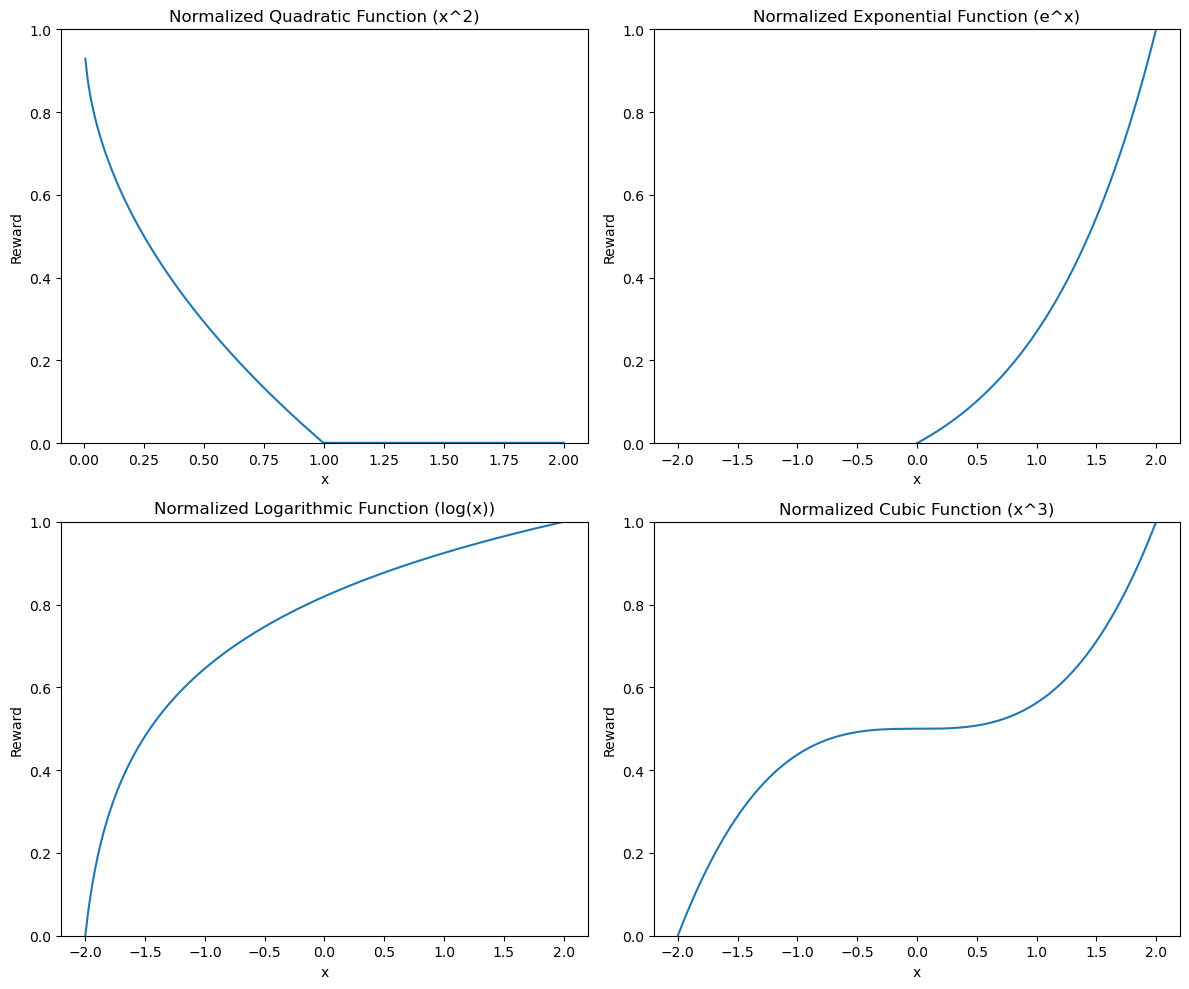

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range for x values
x = np.linspace(-2, 2, 400)

# Define the reward functions
def normalized_quadratic_function(x):
    return np.maximum(1e-3, 1 - np.sqrt(x))

def normalized_exponential_function(x):
    return (np.exp(x) - 1) / (np.exp(2) - 1)

def normalized_logarithmic_function(x):
    return (np.log(x + 2.1) - np.log(0.1)) / (np.log(4.1) - np.log(0.1))

def normalized_cubic_function(x):
    return (x**3 + 8) / 16.0

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Normalized Quadratic Function
axs[0, 0].plot(x, normalized_quadratic_function(x))
axs[0, 0].set_title('Normalized Quadratic Function (x^2)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Reward')
axs[0, 0].set_ylim([0, 1])

# Plot Normalized Exponential Function
axs[0, 1].plot(x, normalized_exponential_function(x))
axs[0, 1].set_title('Normalized Exponential Function (e^x)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Reward')
axs[0, 1].set_ylim([0, 1])

# Plot Normalized Logarithmic Function
axs[1, 0].plot(x, normalized_logarithmic_function(x))
axs[1, 0].set_title('Normalized Logarithmic Function (log(x))')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Reward')
axs[1, 0].set_ylim([0, 1])

# Plot Normalized Cubic Function
axs[1, 1].plot(x, normalized_cubic_function(x))
axs[1, 1].set_title('Normalized Cubic Function (x^3)')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Reward')
axs[1, 1].set_ylim([0, 1])

# Adjust layout
plt.tight_layout()
plt.show()


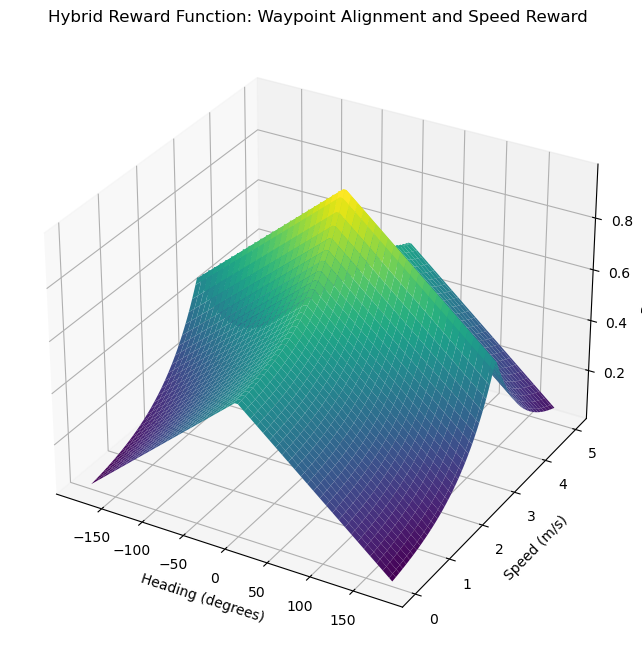

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math

# Define the range for heading and speed values
heading_range = np.linspace(-180, 180, 100)
speed_range = np.linspace(0, 5, 100)
heading, speed = np.meshgrid(heading_range, speed_range)

# Define the hybrid reward function
def hybrid_reward_function_1(heading, speed, target_speed=3.0):
    # Waypoint alignment reward
    direction = 0  # Assuming the ideal direction is 0 degrees for simplicity
    alignment_reward = np.maximum(1.0 - (np.abs(heading - direction) / 180.0), 0.0)
    
    # Speed reward
    speed_reward = np.exp(-np.abs(speed - target_speed))
    
    # Combined reward
    reward = 0.5 * alignment_reward + 0.5 * speed_reward
    return reward

# Calculate rewards
rewards = hybrid_reward_function_1(heading, speed)

# Plotting the 3D surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(heading, speed, rewards, cmap='viridis')

ax.set_title('Hybrid Reward Function: Waypoint Alignment and Speed Reward')
ax.set_xlabel('Heading (degrees)')
ax.set_ylabel('Speed (m/s)')
ax.set_zlabel('Reward')
plt.show()


/tmp/ipykernel_4518/4087513341.py:9: RuntimeWarning: divide by zero encountered in log
  center_reward = np.log(1 + (1 - (distance_from_center / (track_width / 2.0))))
/home/ymarca/anaconda3/envs/deeplearning/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


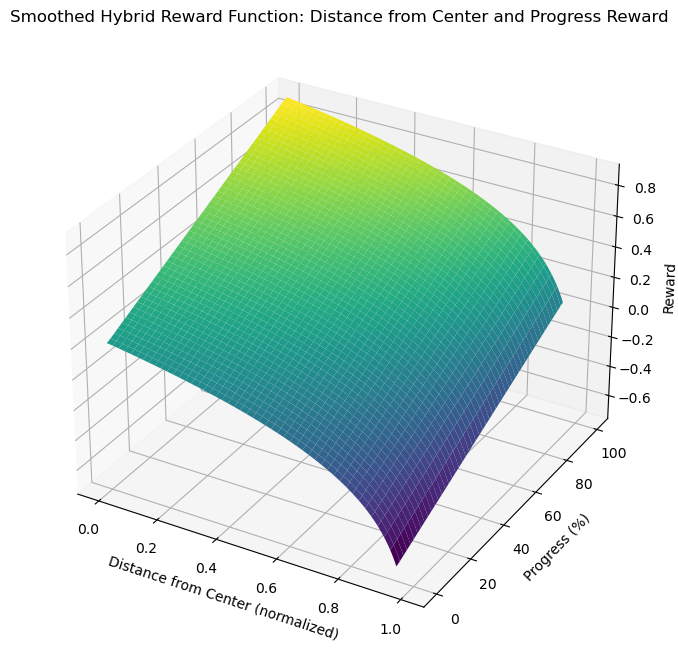

In [15]:
# Define the range for distance_from_center and progress values with higher resolution
distance_from_center_range = np.linspace(0, 1, 200)
progress_range = np.linspace(0, 100, 200)
distance_from_center, progress = np.meshgrid(distance_from_center_range, progress_range)

# Define the hybrid reward function
def hybrid_reward_function_2(distance_from_center, progress, track_width=1.0):
    # Distance from center reward
    center_reward = np.log(1 + (1 - (distance_from_center / (track_width / 2.0))))
    
    # Progress reward (assuming progress is a value between 0 and 100)
    progress_reward = progress / 100.0
    
    # Combined reward
    reward = 0.3 * center_reward + 0.7 * progress_reward
    return reward

# Calculate rewards
rewards = hybrid_reward_function_2(distance_from_center, progress)

# Apply Gaussian filter for smoothing
smoothed_rewards = gaussian_filter(rewards, sigma=2)

# Plotting the 3D surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(distance_from_center, progress, smoothed_rewards, cmap='viridis')

ax.set_title('Smoothed Hybrid Reward Function: Distance from Center and Progress Reward')
ax.set_xlabel('Distance from Center (normalized)')
ax.set_ylabel('Progress (%)')
ax.set_zlabel('Reward')
plt.show()


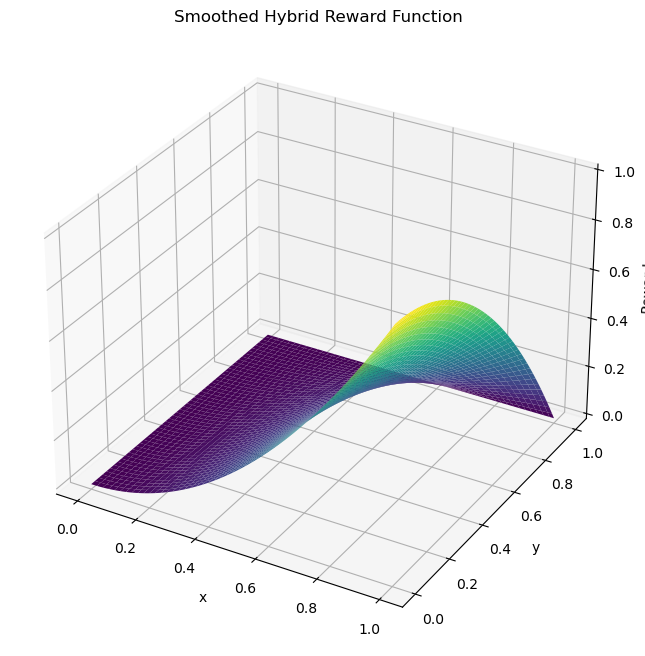

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)

# Calculate rewards
rewards = X**2 * (-Y**2 + 1)

# Plotting the 3D surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, rewards, cmap='viridis')

ax.set_title('Smoothed Hybrid Reward Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Reward')
plt.show()

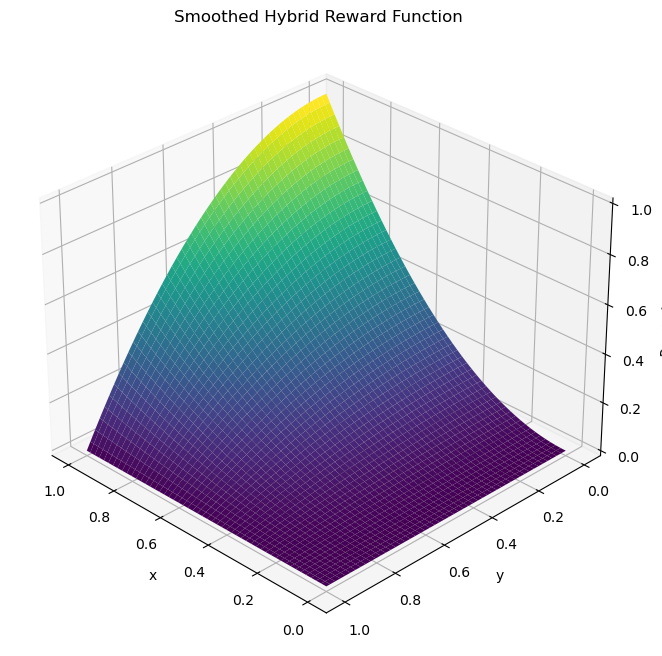

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the x and y arrays
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)

# Create the meshgrid
X, Y = np.meshgrid(x, y)

# Calculate the rewards
rewards = X**2 * (-Y**2 + 1)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with a colormap
ax.plot_surface(X, Y, rewards, cmap='viridis')

# Set labels and title
ax.set_title('Smoothed Hybrid Reward Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Reward')

# Rotate the plot for better visualization
ax.view_init(elev=30, azim=135)  # Adjust elevation and azimuth angles as needed

plt.show()